In [54]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models
from torchvision import transforms
from collections import OrderedDict
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

In [55]:
torch.__version__

'0.4.1'

In [157]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print device

cuda


In [165]:
# Pretrained model
vgg19 = models.vgg19(pretrained=True).to(device).eval()

In [267]:
VG = '../dumps/vg.jpg'
TUE = '../dumps/tue.jpg'

In [268]:
# Loading image
import matplotlib.pyplot as plt
from torchvision import transforms

def process(path):
    img = plt.imread(path)
    transformer = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
        ]
    )
    return transformer(img).to(device)

def show_image(img):
    img = img.squeeze(0)
    img = img.numpy()
    img = img.swapaxes(0, 2)
    img = img.swapaxes(0, 1)
    print img.shape
    plt.imshow(img)
    plt.show()

In [269]:
tue = process(TUE)
vg = process(VG)

tue = tue.unsqueeze(0)
vg = vg.unsqueeze(0)

In [270]:
# Training
style = torch.autograd.Variable(vg).to(device) # Style from Van-Gogh image
content = torch.autograd.Variable(tue).to(device) # Content from TUE
output = torch.rand(vg.size(), requires_grad=True).to(device)

# output.size()

In [271]:
# Function to be recomputed in each step
# Register forward hook & extract internal network features
features = []

def save_features(self, inp, out):
    features.append(out)

for layer in vgg19.features:
    if isinstance(layer, torch.nn.ReLU):
        layer._forward_hooks = OrderedDict()
        layer.register_forward_hook(save_features)

In [272]:
# Precomputed content features
vgg19.features.forward(tue)
tue_features = copy.copy(features)
features = []

In [273]:
# Precomputed style features
vgg19.features.forward(vg)
vg_features = copy.copy(features)
features = []

In [274]:
(tue_features[0] - vg_features[0]).sum()

tensor(-151864.4375, device='cuda:0', grad_fn=<SumBackward0>)

In [275]:
# Losses
def content_loss(radom_fm, content_fm):
    '''

    Content loss by Gatys et al.

    Parameters
    ----------
    radom_fm: torch.Tensor
        Feature map for random image
    content_fm:
        Feature map for style image

    Returns
    -------

    '''

    return 0.5 * ((radom_fm - content_fm) ** 2).sum()


def style_loss(radom_fm, style_fm):
    '''

    Style loss by Gatys et al.

    Parameters
    ----------
    radom_fm: torch.Tensor
        Feature map for random image
    style_fm:
        Feature map for style image

    Returns
    -------

    '''

    a = gram_matrix(radom_fm)
    g = gram_matrix(style_fm)
    
    #print a.shape

    N = a.shape[0]
    M = a.shape[1] #* a.shape[2]
    
    loss = 0.5 * ((g - a) ** 2).sum()
    #loss = 1./(4 * N**2 * M**2) * ((g- a)**2).sum()
    return loss

def gram_matrix(x):
    #print x.size()
    a, b, c, d = x.size()
    features = x.view(a * b, c*d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c *d)

def get_loss(random_fm_list, content_fm_list, style_fm_list, alpha=0.001):

    # print "Getting loss..."
    
    #print len(random_fm_list), len(content_fm_list), len(style_fm_list)

    style_loss_vals =[]
    content_loss_vals = []

    for rf, cf, sf in zip(random_fm_list, content_fm_list, style_fm_list):
        style_loss_vals.append(style_loss(rf, sf)*10000)
        content_loss_vals.append(alpha * content_loss(rf, cf))
    
    sl = sum(style_loss_vals)
    cl = sum(content_loss_vals)

    return sl + cl, sl, cl

In [276]:
# Optimizing
EPOCHS = 100

In [277]:
optimized_param = torch.nn.Parameter(output.data)
opt = torch.optim.LBFGS([optimized_param.requires_grad_()])

In [278]:
#vgg19.features.forward(optimized_param)
#output_features = copy.copy(features)
#features = []
# output_features[0].shape

In [279]:
def loss_fun():
    opt.zero_grad()
    global features
    vgg19.features.forward(optimized_param)
    output_features = copy.copy(features)
    features = []
    output_features[0].shape
    
    global s_loss, c_loss
    
    total_loss, s_loss, c_loss = get_loss(output_features, tue_features, vg_features)
    total_loss.backward(retain_graph=True)
    return total_loss

In [280]:
features

[]

In [281]:
for i in range(EPOCHS):
    loss_val = opt.step(loss_fun)
    #show_image(optimized_param.data)
    print "Iter {}: {} | style loss: {} | content loss: {}".format(i, loss_val, s_loss, c_loss)

Iter 0: 414919.375 | style loss: 22575.2734375 | content loss: 61129.0664062
Iter 1: 81559.5546875 | style loss: 14973.9462891 | content loss: 47189.828125
Iter 2: 61581.5195312 | style loss: 12786.4804688 | content loss: 40295.625
Iter 3: 52618.5 | style loss: 11757.7666016 | content loss: 35643.4726562
Iter 4: 47226.6875 | style loss: 11151.2724609 | content loss: 32627.0078125
Iter 5: 43634.9921875 | style loss: 10688.0878906 | content loss: 30482.6503906
Iter 6: 41067.09375 | style loss: 10450.5332031 | content loss: 28870.0019531
Iter 7: 39252.28125 | style loss: 10214.7890625 | content loss: 27750.4101562
Iter 8: 37919.40625 | style loss: 10072.1464844 | content loss: 26840.3046875
Iter 9: 36876.2421875 | style loss: 9899.88867188 | content loss: 26181.109375
Iter 10: 36054.0078125 | style loss: 9781.17675781 | content loss: 25674.2539062
Iter 11: 35436.140625 | style loss: 9669.94726562 | content loss: 25288.0957031
Iter 12: 34939.53125 | style loss: 9611.96484375 | content loss

KeyboardInterrupt: 

In [282]:
#show_image(output.data)

In [283]:
def show_image_revert(img):
    mean = [0.485, 0.456, 0.406]
    std =[0.229, 0.224, 0.225]
    img = img.squeeze(0)
    img = img.cpu().numpy()
    img = img.swapaxes(0, 2)
    img = img.swapaxes(0, 1)
    img = (img * std) + mean
    print img.shape
    plt.imshow(img)
    plt.show()

(256, 256, 3)


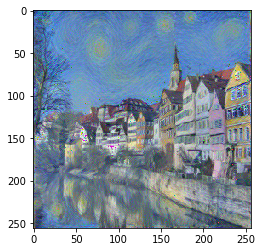

In [284]:
show_image_revert(output.data)

(256, 256, 3)


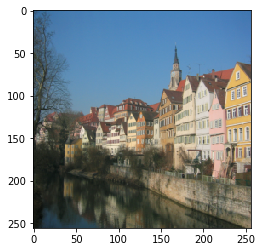

In [102]:
show_image_revert(tue)